C:\ANACONDA\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
  File "C:\ANACONDA\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ANACONDA\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ANACONDA\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ANACONDA\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


+-------------+------------+------------+---------------------+---------------------+
|   Dataset   | Classifier | Technique  |      Comparison     |      Individual     |
+-------------+------------+------------+---------------------+---------------------+
|   Mozilla   |    KNN     |   TF-IDF   |  0.5219989278134151 |  0.5219989278134151 |
|   Mozilla   |     NB     |   TF-IDF   |  0.5270608959824347 |  0.5270608959824347 |
|   Mozilla   |     NN     |   TF-IDF   |  0.5282433162146357 |  0.5282433162146357 |
|   Mozilla   |     RF     |   TF-IDF   |  0.5359058127913717 |  0.5359058127913717 |
|   Mozilla   |    SVM     |   TF-IDF   |  0.5318990366764543 |  0.5318990366764543 |
|   Eclipse   |    KNN     |   TF-IDF   |  0.5183957555506833 |  0.5183957555506833 |
|   Eclipse   |     NB     |   TF-IDF   |  0.5226874526426254 |  0.5226874526426254 |
|   Eclipse   |     NN     |   TF-IDF   |  0.5218819047524543 |  0.5218819047524543 |
|   Eclipse   |     RF     |   TF-IDF   |  0.521476524

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

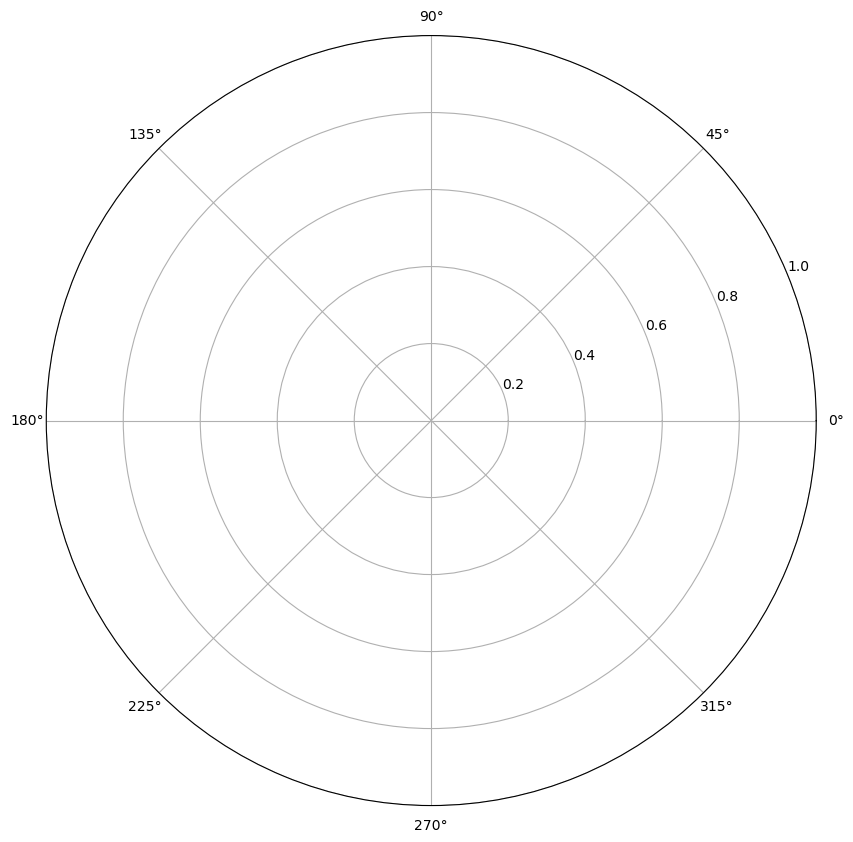

In [1]:
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
import matplotlib.pyplot as plt

# Suppress warnings
simplefilter("ignore", category=UserWarning)
simplefilter("ignore", category=UserWarning, append=True)
simplefilter("ignore", category=ConvergenceWarning, append=True)

def load_and_preprocess_data(data_path):
    bug_reports = pd.read_csv(data_path)

    bug_reports['creation_date'] = pd.to_datetime(bug_reports['creation_date'], errors='coerce')
    bug_reports['resolution_date'] = pd.to_datetime(bug_reports['resolution_date'])
    bug_reports['bug_fix_time'] = (bug_reports['resolution_date'] - bug_reports['creation_date']).dt.days
    bug_reports = bug_reports.dropna(subset=['bug_fix_time', 'short_description'])

    threshold = 10
    bug_reports['bug_class'] = np.where(bug_reports['bug_fix_time'] <= threshold, 'short-lived', 'long-lived')

    return bug_reports

def extract_tfidf_features(bug_reports):
    tfidf_vectorizer = TfidfVectorizer(max_features=128, stop_words='english')
    tfidf_features = tfidf_vectorizer.fit_transform(bug_reports['short_description']).toarray()

    return tfidf_features

def extract_distilbert_features(bug_reports):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    def extract_distilbert_feature(text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

    distilbert_features = np.array(bug_reports['short_description'].apply(extract_distilbert_feature).tolist())
    distilbert_features = torch.tensor(distilbert_features)

    return distilbert_features

def extract_gcn_features(bug_reports):
    # Implement GCN feature extraction here
    # Placeholder code for illustration purposes
    gcn_features = np.random.rand(len(bug_reports), 128)
    return gcn_features

def extract_rnn_features(bug_reports):
    # Implement RNN feature extraction here
    # Placeholder code for illustration purposes
    rnn_features = np.random.rand(len(bug_reports), 128)
    return rnn_features

def train_and_evaluate_classifier(X_train, X_test, y_train, y_test, classifier, feature_type):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)

    cm = confusion_matrix(y_test, predictions)
    balanced_accuracy = np.mean([cm[i, i] / np.sum(cm[i]) for i in range(len(np.unique(y_test)))])
    
    return balanced_accuracy

def print_results_table(datasets, classifiers, individual_results_tfidf, mean_accuracies_tfidf, individual_results_distilbert, mean_accuracies_distilbert, individual_results_gcn, mean_accuracies_gcn, individual_results_rnn, mean_accuracies_rnn):
    result_table = PrettyTable()

    # Add headers
    result_table.field_names = ["Dataset", "Classifier", "Technique", "Comparison", "Individual"]

    # Add data for TF-IDF
    best_acc_tfidf = -1
    best_acc_details_tfidf = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_tfidf[i][j] > best_acc_tfidf:
                best_acc_tfidf = mean_accuracies_tfidf[i][j]
                best_acc_details_tfidf = [datasets[i], classifiers[j], 'TF-IDF', best_acc_tfidf, individual_results_tfidf[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'TF-IDF', mean_accuracies_tfidf[i][j], individual_results_tfidf[i][j]])

    # Add data for DistilBERT
    best_acc_distilbert = -1
    best_acc_details_distilbert = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_distilbert[i][j] > best_acc_distilbert:
                best_acc_distilbert = mean_accuracies_distilbert[i][j]
                best_acc_details_distilbert = [datasets[i], classifiers[j], 'DistilBERT', best_acc_distilbert, individual_results_distilbert[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'DistilBERT', mean_accuracies_distilbert[i][j], individual_results_distilbert[i][j]])

    # Add data for GCN
    best_acc_gcn = -1
    best_acc_details_gcn = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_gcn[i][j] > best_acc_gcn:
                best_acc_gcn = mean_accuracies_gcn[i][j]
                best_acc_details_gcn = [datasets[i], classifiers[j], 'GCN', best_acc_gcn, individual_results_gcn[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'GCN', mean_accuracies_gcn[i][j], individual_results_gcn[i][j]])

    # Add data for RNN
    best_acc_rnn = -1
    best_acc_details_rnn = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_rnn[i][j] > best_acc_rnn:
                best_acc_rnn = mean_accuracies_rnn[i][j]
                best_acc_details_rnn = [datasets[i], classifiers[j], 'RNN', best_acc_rnn, individual_results_rnn[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'RNN', mean_accuracies_rnn[i][j], individual_results_rnn[i][j]])

    # Print the table
    print(result_table)

    # Print the table with best accuracy details
    best_acc_table = PrettyTable()
    best_acc_table.field_names = ["Dataset", "Classifier", "Technique", "Best Accuracy", "Details"]
    best_acc_table.add_row(best_acc_details_tfidf)
    best_acc_table.add_row(best_acc_details_distilbert)
    best_acc_table.add_row(best_acc_details_gcn)
    best_acc_table.add_row(best_acc_details_rnn)

    print("\nBest Accuracy Details:")
    print(best_acc_table)

def plot_spider_chart(classifiers, datasets, accuracies_tfidf, accuracies_distilbert, accuracies_gcn, accuracies_rnn):
    N = len(classifiers)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i in range(len(datasets)):
        values_tfidf = accuracies_tfidf[i]
        values_distilbert = accuracies_distilbert[i]
        values_gcn = accuracies_gcn[i]
        values_rnn = accuracies_rnn[i]
        values_tfidf += values_tfidf[:1]
        values_distilbert += values_distilbert[:1]
        values_gcn += values_gcn[:1]
        values_rnn += values_rnn[:1]

        ax.plot(angles, values_tfidf, label=f'{datasets[i]} TF-IDF')
        ax.plot(angles, values_distilbert, label=f'{datasets[i]} DistilBERT')
        ax.plot(angles, values_gcn, label=f'{datasets[i]} GCN')
        ax.plot(angles, values_rnn, label=f'{datasets[i]} RNN')

    ax.fill(angles, values_tfidf, alpha=0.1)
    ax.fill(angles, values_distilbert, alpha=0.1)
    ax.fill(angles, values_gcn, alpha=0.1)
    ax.fill(angles, values_rnn, alpha=0.1)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classifiers)

    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Comparison of Classifiers Across Datasets')
    plt.show()

# Define datasets and classifiers
datasets = ['Mozilla', 'Eclipse', 'GCC', 'GNOME', 'WineHQ', 'FreeDesktop']
classifiers = ['KNN', 'NB', 'NN', 'RF', 'SVM']

# Initialize empty lists for individual and mean accuracies
individual_results_tfidf = []
individual_results_distilbert = []
individual_results_gcn = []
individual_results_rnn = []

mean_accuracies_tfidf = []
mean_accuracies_distilbert = []
mean_accuracies_gcn = []
mean_accuracies_rnn = []

# Load and preprocess data for different projects
data_paths = [
    r'C:\Users\hp\Desktop\New folder (2)\mozilla_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\eclipse_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\gcc_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\gnome_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\winehq_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\freedesktop_bug_report_data.csv'
]
#
for data_path in data_paths:
    bug_reports = load_and_preprocess_data(data_path)

    X_tfidf = extract_tfidf_features(bug_reports)
    X_distilbert = extract_distilbert_features(bug_reports)
    X_gcn = extract_gcn_features(bug_reports)
    X_rnn = extract_rnn_features(bug_reports)
    y = bug_reports['bug_class']

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    accuracies_tfidf = []
    accuracies_distilbert = []
    accuracies_gcn = []
    accuracies_rnn = []

    for train_index, test_index in skf.split(X_tfidf, y):
        X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
        y_train_tfidf, y_test_tfidf = y.iloc[train_index], y.iloc[test_index]

        X_train_distilbert, X_test_distilbert = X_distilbert[train_index], X_distilbert[test_index]
        y_train_distilbert, y_test_distilbert = y.iloc[train_index], y.iloc[test_index]

        X_train_gcn, X_test_gcn = X_gcn[train_index], X_gcn[test_index]
        y_train_gcn, y_test_gcn = y.iloc[train_index], y.iloc[test_index]

        X_train_rnn, X_test_rnn = X_rnn[train_index], X_rnn[test_index]
        y_train_rnn, y_test_rnn = y.iloc[train_index], y.iloc[test_index]

        scaler = MinMaxScaler()
        X_train_distilbert = scaler.fit_transform(X_train_distilbert)
        X_test_distilbert = scaler.transform(X_test_distilbert)
        X_train_gcn = scaler.fit_transform(X_train_gcn)
        X_test_gcn = scaler.transform(X_test_gcn)
        X_train_rnn = scaler.fit_transform(X_train_rnn)
        X_test_rnn = scaler.transform(X_test_rnn)

        accuracies_tfidf.append([
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                KNeighborsClassifier(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                MultinomialNB(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                MLPClassifier(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                RandomForestClassifier(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                SVC(),
                'TF-IDF'
            )
        ])

        accuracies_distilbert.append([
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                KNeighborsClassifier(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                MultinomialNB(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                MLPClassifier(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                RandomForestClassifier(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                SVC(),
                'DistilBERT'
            )
        ])

        accuracies_gcn.append([
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                KNeighborsClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                KNeighborsClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                MLPClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                RandomForestClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                SVC(),
                'GCN'
            )
        ])

        accuracies_rnn.append([
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                KNeighborsClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                KNeighborsClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                MLPClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                RandomForestClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                SVC(),
                'RNN'
            )
        ])

    individual_results_tfidf.append(np.mean(accuracies_tfidf, axis=0))
    individual_results_distilbert.append(np.mean(accuracies_distilbert, axis=0))
    individual_results_gcn.append(np.mean(accuracies_gcn, axis=0))
    individual_results_rnn.append(np.mean(accuracies_rnn, axis=0))

    mean_accuracies_tfidf.append(np.mean(accuracies_tfidf, axis=0))
    mean_accuracies_distilbert.append(np.mean(accuracies_distilbert, axis=0))
    mean_accuracies_gcn.append(np.mean(accuracies_gcn, axis=0))
    mean_accuracies_rnn.append(np.mean(accuracies_rnn, axis=0))

# Print the results table
print_results_table(datasets, classifiers, individual_results_tfidf, mean_accuracies_tfidf, individual_results_distilbert, mean_accuracies_distilbert, individual_results_gcn, mean_accuracies_gcn, individual_results_rnn, mean_accuracies_rnn)

# Plot the spider chart
plot_spider_chart(classifiers, datasets, mean_accuracies_tfidf, mean_accuracies_distilbert, mean_accuracies_gcn, mean_accuracies_rnn)


In [26]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

# Existing results data
df = pd.read_csv('resultss.csv')

# Plotting
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

# Existing results data
df = pd.read_csv('resultss.csv')

# Plotting
def plot_best_accuracy(results):
    datasets = list(results.keys())
    tfidf_accuracies = [max(results[dataset]["TF-IDF"].values()) for dataset in datasets]
    bert_accuracies = [max(results[dataset]["BERT"].values()) for dataset in datasets]
    gcn_accuracies = [max(results[dataset]["GCN"].values()) for dataset in datasets]
    rnn_accuracies = [max(results[dataset]["RNN"].values()) for dataset in datasets]

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    bar_width = 0.2
    bar_positions = np.arange(len(datasets))

    # Plotting the bars
    tfidf_bars = plt.bar(bar_positions - bar_width * 1.5, tfidf_accuracies, width=bar_width, label='TF-IDF', color='red')
    bert_bars = plt.bar(bar_positions - bar_width / 2, bert_accuracies, width=bar_width, label='BERT', color='blue')
    gcn_bars = plt.bar(bar_positions + bar_width / 2, gcn_accuracies, width=bar_width, label='GCN', color='green')
    rnn_bars = plt.bar(bar_positions + bar_width * 1.5, rnn_accuracies, width=bar_width, label='RNN', color='purple')

    # Adding labels on top of each bar
    for tfidf_bar, bert_bar, gcn_bar, rnn_bar in zip(tfidf_bars, bert_bars, gcn_bars, rnn_bars):
        height_tfidf = tfidf_bar.get_height()
        height_bert = bert_bar.get_height()
        height_gcn = gcn_bar.get_height()
        height_rnn = rnn_bar.get_height()
        ax.text(tfidf_bar.get_x() + tfidf_bar.get_width() / 2., height_tfidf, f'{height_tfidf:.3f}', ha='center', va='bottom', color='red')
        ax.text(bert_bar.get_x() + bert_bar.get_width() / 2., height_bert, f'{height_bert:.3f}', ha='center', va='bottom', color='blue')
        ax.text(gcn_bar.get_x() + gcn_bar.get_width() / 2., height_gcn, f'{height_gcn:.3f}', ha='center', va='bottom', color='green')
        ax.text(rnn_bar.get_x() + rnn_bar.get_width() / 2., height_rnn, f'{height_rnn:.3f}', ha='center', va='bottom', color='purple')

    # Adding labels and legend
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Best Accuracy', fontsize=14)
    plt.title('Comparison of TF-IDF, BERT, GCN, and RNN', fontsize=16)
    plt.xticks(bar_positions, datasets, rotation=45, ha='right', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Tabulate and print best method and classifier
def print_best_method_and_classifier(df):
    results = {}  # Dictionary to store results
    for index, row in df.iterrows():
        dataset = row['Dataset']
        classifier = row['Classifier']
        technique = row['Technique']
        comparison = row['Comparison']
        individual = row['Individual']

        if dataset not in results:
            results[dataset] = {}

        if classifier not in results[dataset]:
            results[dataset][classifier] = {}

        results[dataset][classifier][technique] = comparison

    table_data = []
    best_methods = {}
    best_classifiers = {}

    for dataset, methods in results.items():
        best_method = max(methods.keys(), key=lambda method: max(methods[method].values()))
        best_classifier = max(methods[best_method].keys(), key=lambda classifier: methods[best_method][classifier])

        table_data.append([dataset, best_method, best_classifier])
        best_methods[dataset] = best_method
        best_classifiers[dataset] = best_classifier

    # Create the table
    headers = ["Dataset", "Best Method", "Best Classifier"]
    table = tabulate(table_data, headers=headers, tablefmt="pretty")

    # Print the table
    print("\nBest Method and Classifier:")
    print(table)

    return best_methods, best_classifiers

best_methods, best_classifiers = print_best_method_and_classifier(df)

# Find overall best classifier and method
overall_best_dataset = max(best_methods.keys(), key=lambda dataset: df[(df['Dataset'] == dataset) & (df['Classifier'] == best_classifiers[dataset])]['Comparison'].max())
overall_best_classifier = best_classifiers[overall_best_dataset]
overall_best_method = best_methods[overall_best_dataset]
overall_best_accuracy = df[(df['Dataset'] == overall_best_dataset) & (df['Classifier'] == overall_best_classifier) & (df['Technique'] == overall_best_method)]['Comparison'].max()

overall_best_technique = overall_best_method  # Assuming the best technique is the same as the best method

print(f"\nOverall Best Dataset: {overall_best_dataset}")
print(f"Overall Best Classifier: {overall_best_classifier}")
print(f"Overall Best Technique: {overall_best_technique}")
print(f"Overall Best Accuracy: {overall_best_accuracy}")



Best Method and Classifier:
+-------------+-------------+-----------------+
|   Dataset   | Best Method | Best Classifier |
+-------------+-------------+-----------------+
|   Mozilla   |     NN      |   DistilBERT    |
|   Eclipse   |     SVM     |   DistilBERT    |
|     GCC     |     NN      |   DistilBERT    |
|    GNOME    |     NB      |   DistilBERT    |
|   WineHQ    |     NN      |     TF-IDF      |
| FreeDesktop |     NN      |   DistilBERT    |
+-------------+-------------+-----------------+

Overall Best Dataset: Mozilla
Overall Best Classifier: DistilBERT
Overall Best Technique: NN
Overall Best Accuracy: nan



Best Method and Classifier:
+-------------+-------------+-----------------+
|   Dataset   | Best Method | Best Classifier |
+-------------+-------------+-----------------+
|   Mozilla   |     NN      |   DistilBERT    |
|   Eclipse   |     SVM     |   DistilBERT    |
|     GCC     |     NN      |   DistilBERT    |
|    GNOME    |     NB      |   DistilBERT    |
|   WineHQ    |     NN      |     TF-IDF      |
| FreeDesktop |     NN      |   DistilBERT    |
+-------------+-------------+-----------------+

Overall Best Dataset: Mozilla
Overall Best Classifier: DistilBERT
Overall Best Technique: NN
Overall Best Accuracy: nan


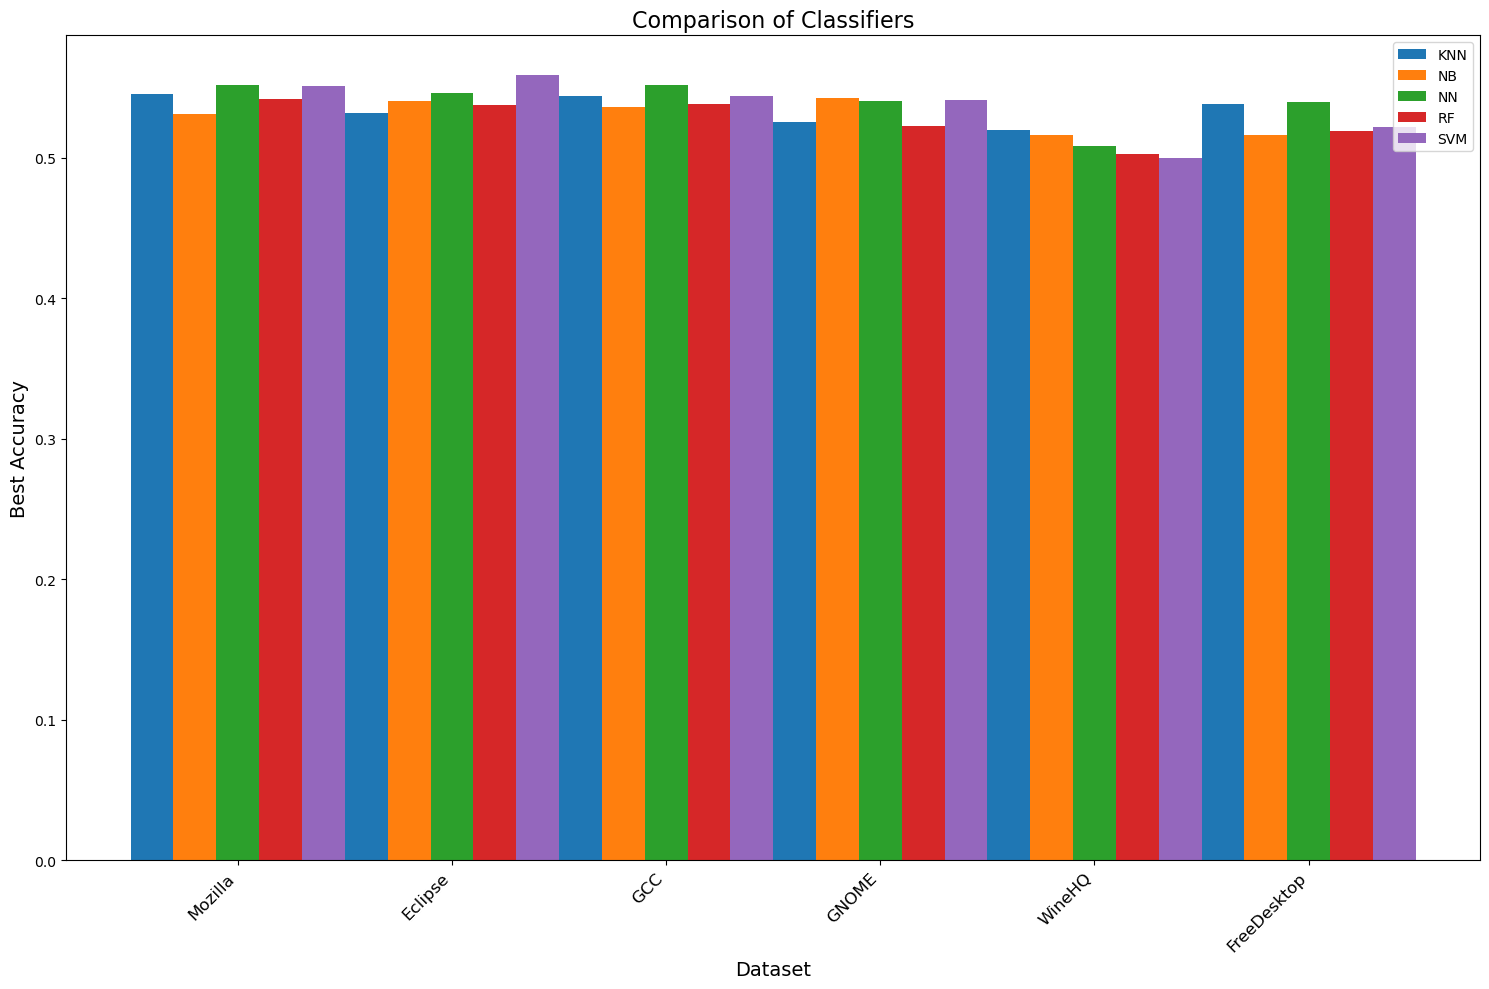

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Plotting function
def plot_best_accuracy(df):
    datasets = df['Dataset'].unique()
    classifiers = df['Classifier'].unique()
    techniques = df['Technique'].unique()

    # Filter out rows where Comparison is NaN
    df_filtered = df.dropna(subset=['Comparison'])

    # Group by Dataset, Classifier, and Technique, and find the max Comparison value
    grouped = df_filtered.groupby(['Dataset', 'Classifier', 'Technique'])['Comparison'].max().reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    bar_width = 0.2
    bar_positions = np.arange(len(datasets))

    for i, classifier in enumerate(classifiers):
        classifier_data = grouped[grouped['Classifier'] == classifier]
        classifier_accuracies = [classifier_data[classifier_data['Dataset'] == dataset]['Comparison'].values[0] if dataset in classifier_data['Dataset'].values else 0 for dataset in datasets]
        plt.bar(bar_positions + (i - len(classifiers)//2) * bar_width, classifier_accuracies, width=bar_width, label=classifier)

    # Adding labels and legend
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Best Accuracy', fontsize=14)
    plt.title('Comparison of Classifiers', fontsize=16)
    plt.xticks(bar_positions, datasets, rotation=45, ha='right', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Tabulate and print best method and classifier
def print_best_method_and_classifier(df):
    results = {}  # Dictionary to store results
    for index, row in df.iterrows():
        dataset = row['Dataset']
        classifier = row['Classifier']
        technique = row['Technique']
        comparison = row['Comparison']
        individual = row['Individual']

        if dataset not in results:
            results[dataset] = {}

        if classifier not in results[dataset]:
            results[dataset][classifier] = {}

        results[dataset][classifier][technique] = comparison

    table_data = []
    best_methods = {}
    best_classifiers = {}

    for dataset, methods in results.items():
        best_method = max(methods.keys(), key=lambda method: max(methods[method].values()))
        best_classifier = max(methods[best_method].keys(), key=lambda classifier: methods[best_method][classifier])

        table_data.append([dataset, best_method, best_classifier])
        best_methods[dataset] = best_method
        best_classifiers[dataset] = best_classifier

    # Create the table
    headers = ["Dataset", "Best Method", "Best Classifier"]
    table = tabulate(table_data, headers=headers, tablefmt="pretty")

    # Print the table
    print("\nBest Method and Classifier:")
    print(table)

    return best_methods, best_classifiers

best_methods, best_classifiers = print_best_method_and_classifier(df)

# Find overall best classifier and method
overall_best_dataset = max(best_methods.keys(), key=lambda dataset: df[(df['Dataset'] == dataset) & (df['Classifier'] == best_classifiers[dataset])]['Comparison'].max())
overall_best_classifier = best_classifiers[overall_best_dataset]
overall_best_method = best_methods[overall_best_dataset]
overall_best_accuracy = df[(df['Dataset'] == overall_best_dataset) & (df['Classifier'] == overall_best_classifier) & (df['Technique'] == overall_best_method)]['Comparison'].max()

overall_best_technique = overall_best_method  # Assuming the best technique is the same as the best method

print(f"\nOverall Best Dataset: {overall_best_dataset}")
print(f"Overall Best Classifier: {overall_best_classifier}")
print(f"Overall Best Technique: {overall_best_technique}")
print(f"Overall Best Accuracy: {overall_best_accuracy}")

# Plotting the best accuracy
plot_best_accuracy(df)



Best Method and Classifier:
+-------------+-------------+-----------------+
|   Dataset   | Best Method | Best Classifier |
+-------------+-------------+-----------------+
|   Mozilla   |     NN      |   DistilBERT    |
|   Eclipse   |     SVM     |   DistilBERT    |
|     GCC     |     NN      |   DistilBERT    |
|    GNOME    |     NB      |   DistilBERT    |
|   WineHQ    |     NN      |     TF-IDF      |
| FreeDesktop |     NN      |   DistilBERT    |
+-------------+-------------+-----------------+

Overall Best Dataset: Mozilla
Overall Best Classifier: DistilBERT
Overall Best Technique: NN
Overall Best Accuracy: nan


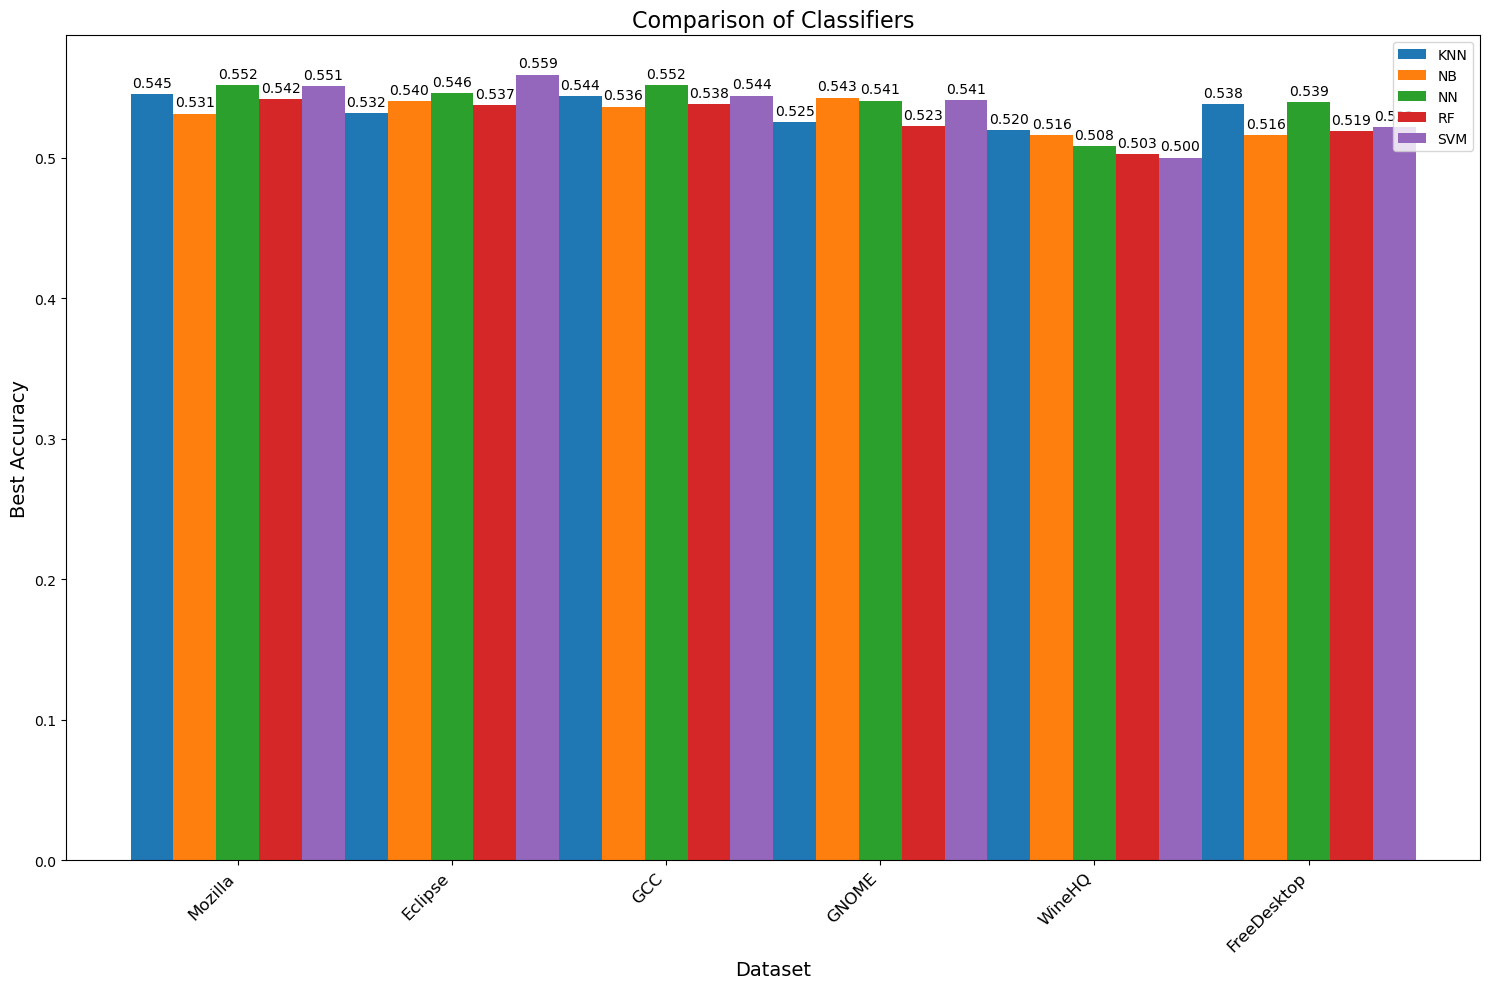

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Plotting function
def plot_best_accuracy(df):
    datasets = df['Dataset'].unique()
    classifiers = df['Classifier'].unique()
    techniques = df['Technique'].unique()

    # Filter out rows where Comparison is NaN
    df_filtered = df.dropna(subset=['Comparison'])

    # Group by Dataset, Classifier, and Technique, and find the max Comparison value
    grouped = df_filtered.groupby(['Dataset', 'Classifier', 'Technique'])['Comparison'].max().reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    bar_width = 0.2
    bar_positions = np.arange(len(datasets))

    for i, classifier in enumerate(classifiers):
        classifier_data = grouped[grouped['Classifier'] == classifier]
        classifier_accuracies = [classifier_data[classifier_data['Dataset'] == dataset]['Comparison'].values[0] if dataset in classifier_data['Dataset'].values else 0 for dataset in datasets]
        bars = plt.bar(bar_positions + (i - len(classifiers)//2) * bar_width, classifier_accuracies, width=bar_width, label=classifier)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Adding labels and legend
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Best Accuracy', fontsize=14)
    plt.title('Comparison of Classifiers', fontsize=16)
    plt.xticks(bar_positions, datasets, rotation=45, ha='right', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Tabulate and print best method and classifier
def print_best_method_and_classifier(df):
    results = {}  # Dictionary to store results
    for index, row in df.iterrows():
        dataset = row['Dataset']
        classifier = row['Classifier']
        technique = row['Technique']
        comparison = row['Comparison']
        individual = row['Individual']

        if dataset not in results:
            results[dataset] = {}

        if classifier not in results[dataset]:
            results[dataset][classifier] = {}

        results[dataset][classifier][technique] = comparison

    table_data = []
    best_methods = {}
    best_classifiers = {}

    for dataset, methods in results.items():
        best_method = max(methods.keys(), key=lambda method: max(methods[method].values()))
        best_classifier = max(methods[best_method].keys(), key=lambda classifier: methods[best_method][classifier])

        table_data.append([dataset, best_method, best_classifier])
        best_methods[dataset] = best_method
        best_classifiers[dataset] = best_classifier

    # Create the table
    headers = ["Dataset", "Best Method", "Best Classifier"]
    table = tabulate(table_data, headers=headers, tablefmt="pretty")

    # Print the table
    print("\nBest Method and Classifier:")
    print(table)

    return best_methods, best_classifiers

best_methods, best_classifiers = print_best_method_and_classifier(df)

# Find overall best classifier and method
overall_best_dataset = max(best_methods.keys(), key=lambda dataset: df[(df['Dataset'] == dataset) & (df['Classifier'] == best_classifiers[dataset])]['Comparison'].max())
overall_best_classifier = best_classifiers[overall_best_dataset]
overall_best_method = best_methods[overall_best_dataset]
overall_best_accuracy = df[(df['Dataset'] == overall_best_dataset) & (df['Classifier'] == overall_best_classifier) & (df['Technique'] == overall_best_method)]['Comparison'].max()

overall_best_technique = overall_best_method  # Assuming the best technique is the same as the best method

print(f"\nOverall Best Dataset: {overall_best_dataset}")
print(f"Overall Best Classifier: {overall_best_classifier}")
print(f"Overall Best Technique: {overall_best_technique}")
print(f"Overall Best Accuracy: {overall_best_accuracy}")

# Plotting the best accuracy
plot_best_accuracy(df)


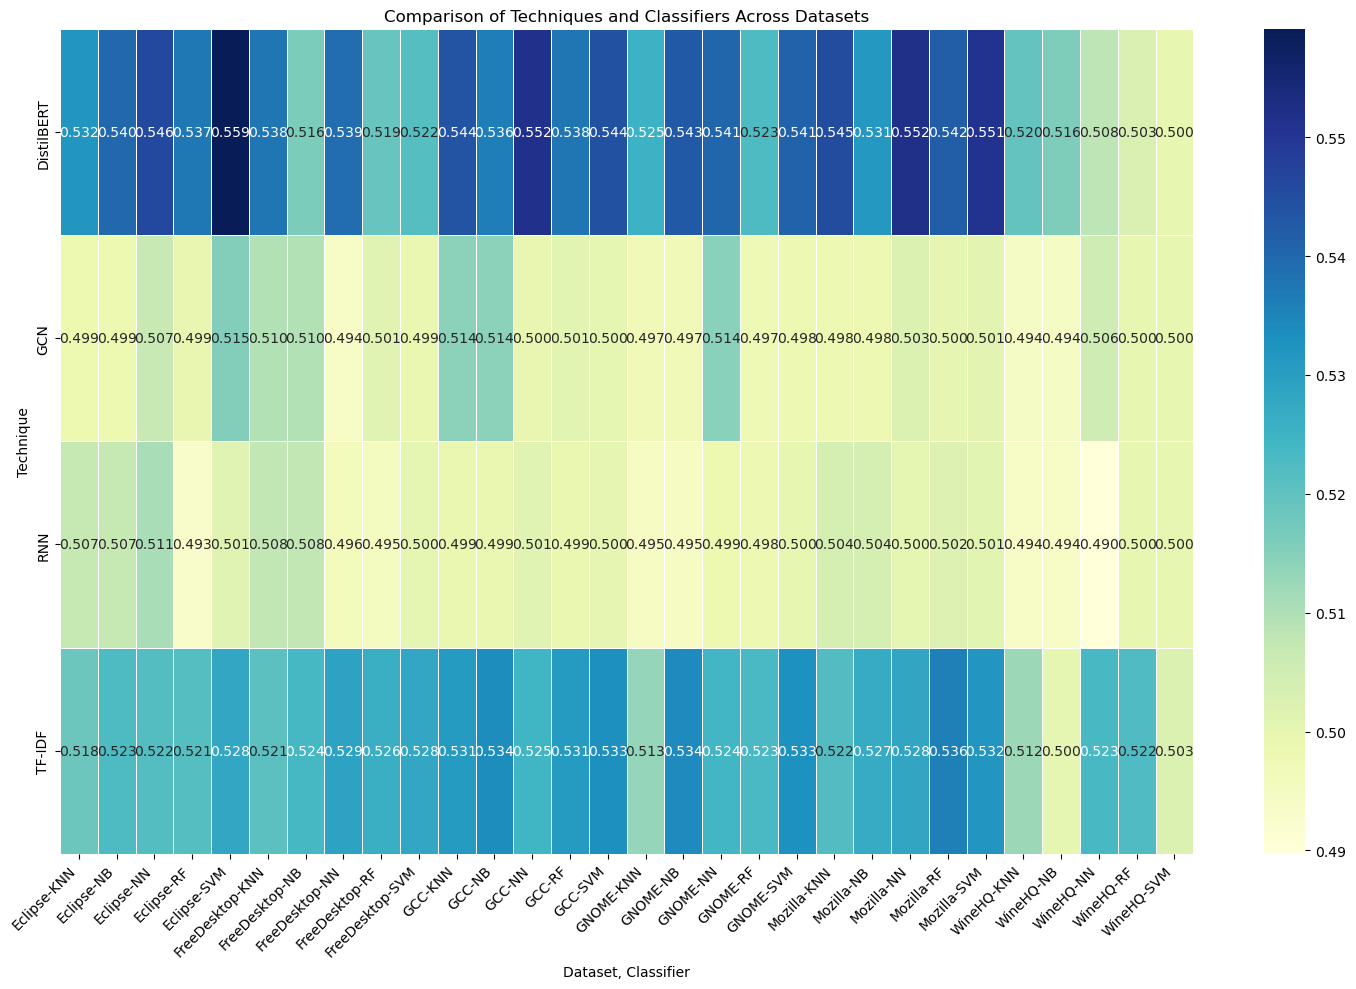

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for heatmap
pivot_df = df_filtered.pivot_table(index='Technique', columns=['Dataset', 'Classifier'], values='Comparison')

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5)
plt.title('Comparison of Techniques and Classifiers Across Datasets')
plt.xlabel('Dataset, Classifier')
plt.ylabel('Technique')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_6544\4266409608.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1500x1000 with 0 Axes>

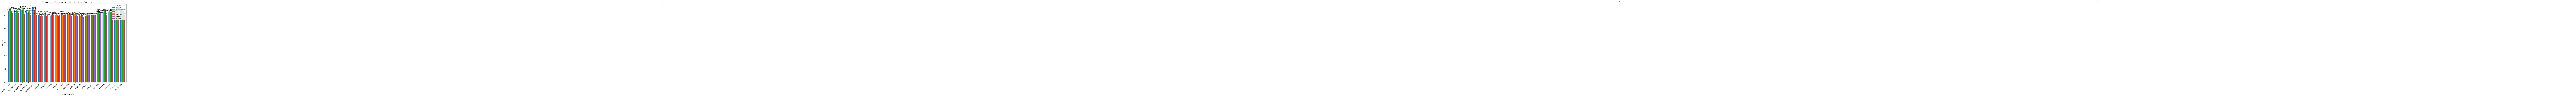

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for plotting
pivot_df = df_filtered.pivot_table(index=['Technique', 'Classifier'], columns='Dataset', values='Comparison')

# Plotting the bar chart with separate bar groups
plt.figure(figsize=(15, 10))
ax = pivot_df.plot(kind='bar', figsize=(15, 10), width=0.8)  # Adjust the width as needed for separation
plt.title('Comparison of Techniques and Classifiers Across Datasets')
plt.xlabel('Technique, Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

# Adding labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, xytext=(0, 5),
                textcoords='offset points')

# Adding dataset names above each bar group
for idx, col in enumerate(pivot_df.columns):
    ax.text(idx * 4 + 1.5, 1.02, col[1], ha='center', va='bottom', transform=ax.transAxes, fontsize=8)

plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (5,) and (25,)

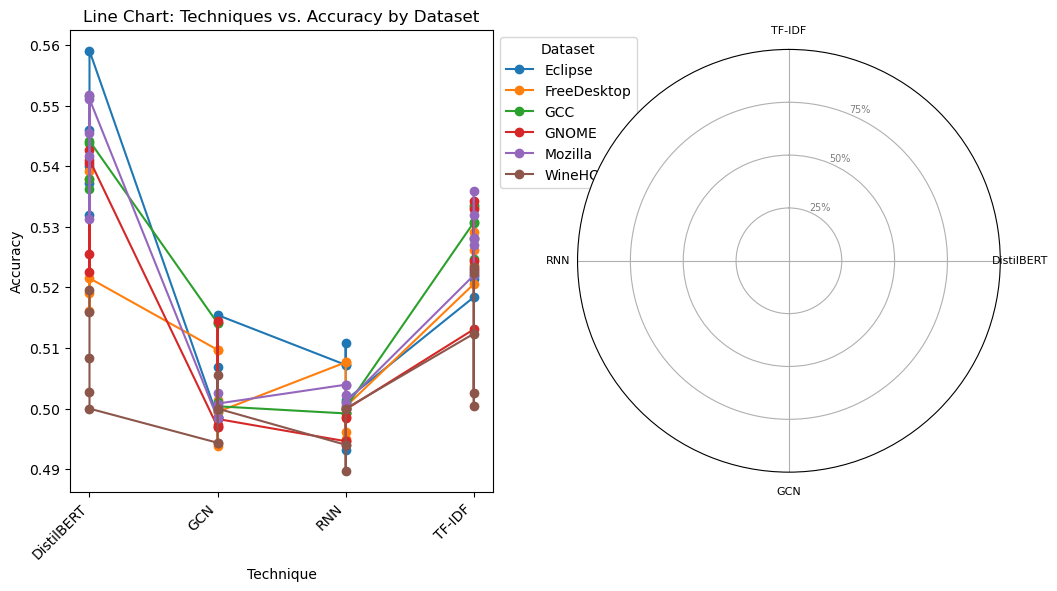

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# Read data from CSV
df = pd.read_csv('results.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for plotting
pivot_df = df_filtered.pivot_table(index=['Technique', 'Classifier'], columns='Dataset', values='Comparison')

# Line chart for datasets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for dataset in pivot_df.columns:
    plt.plot(pivot_df.index.get_level_values('Technique'), pivot_df[dataset], marker='o', label=dataset)

plt.title('Line Chart: Techniques vs. Accuracy by Dataset')
plt.xlabel('Technique')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', loc='upper left', bbox_to_anchor=(1, 1))

# Radar chart for classifiers and techniques
plt.subplot(1, 2, 2, polar=True)
categories = techniques
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(1, 2, 2, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories, fontsize=8)
plt.yticks([25, 50, 75], ["25%", "50%", "75%"], color="grey", size=7)
plt.ylim(0, 100)

# Plot radar chart for each classifier
for idx, classifier in enumerate(classifiers):
    values = pivot_df.loc[(slice(None), classifier), :].values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid', label=classifier)

plt.title('Radar Chart: Classifiers and Techniques Accuracy')
plt.legend(title='Classifier', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


<Figure size 1800x1000 with 0 Axes>

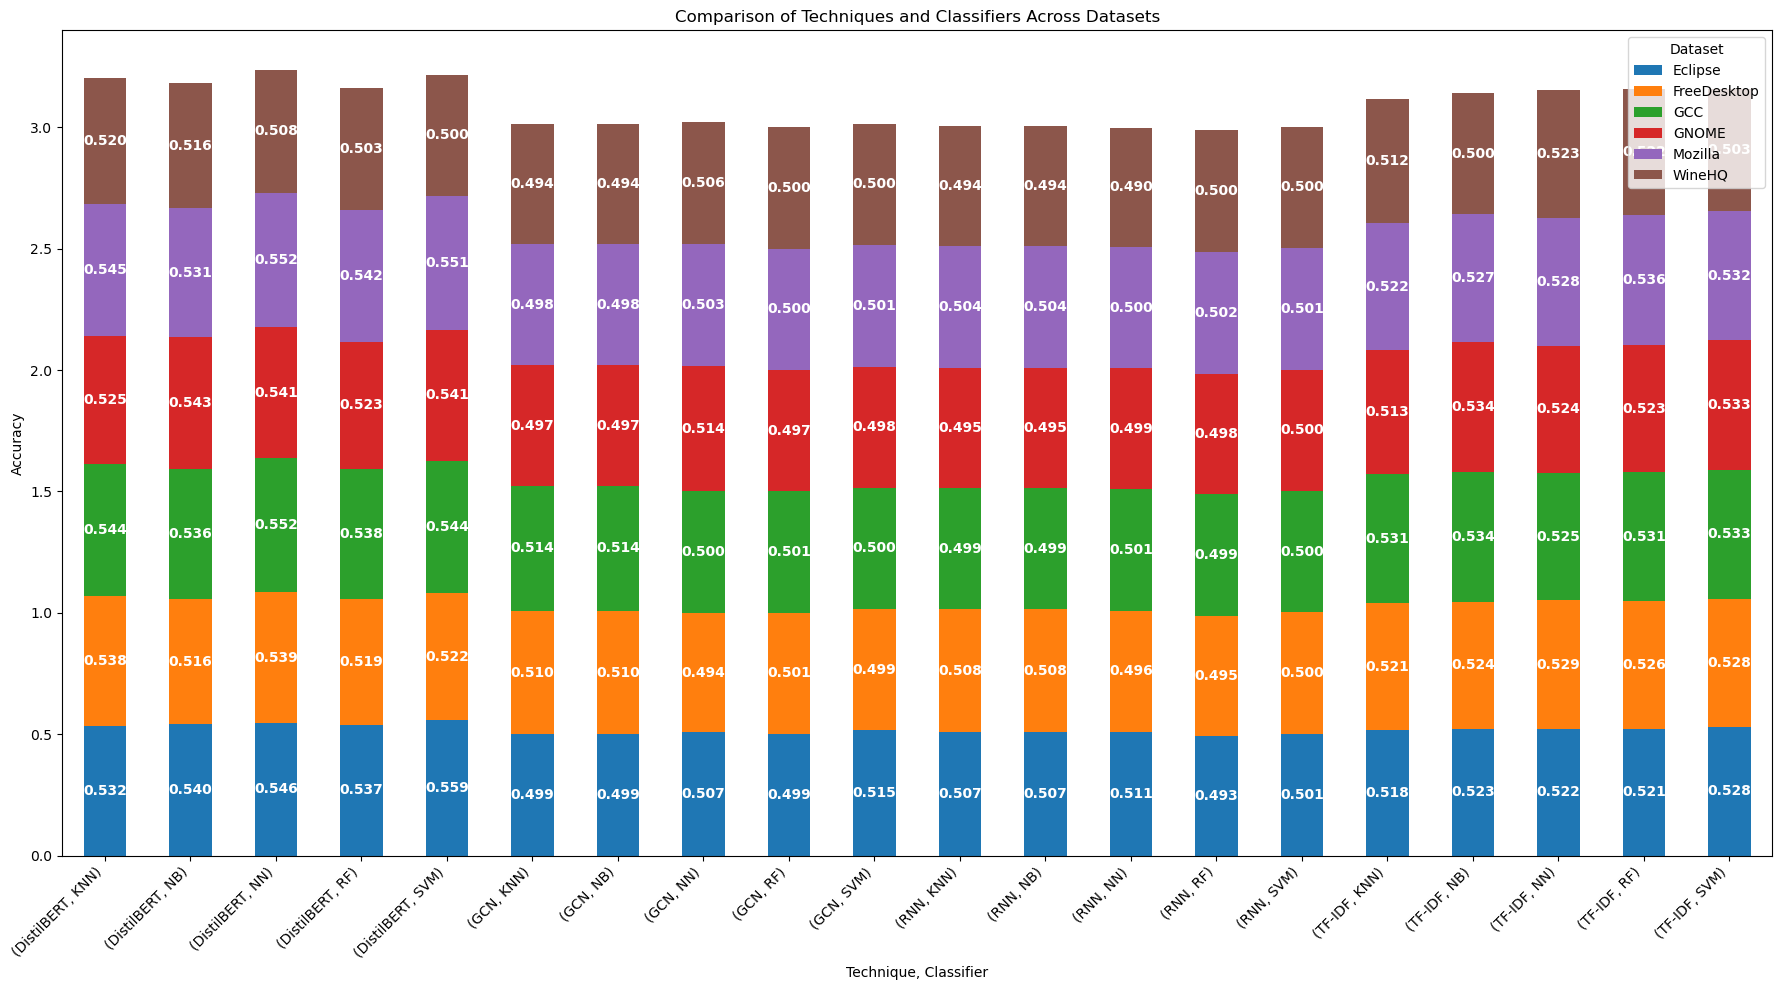

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for plotting
pivot_df = df_filtered.pivot_table(index=['Technique', 'Classifier'], columns='Dataset', values='Comparison')

# Plotting the bar chart
plt.figure(figsize=(18, 10))
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(18, 10))
plt.title('Comparison of Techniques and Classifiers Across Datasets')
plt.xlabel('Technique, Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

# Adding labels inside each bar section
for c in ax.containers:
    # Optional: if the bar is too small, adjust the text position
    for i, child in enumerate(c.get_children()):
        height = child.get_height()
        if height > 0:  # Only annotate sections with height > 0
            ax.annotate(f'{height:.3f}', 
                        (child.get_x() + child.get_width() / 2, child.get_y() + height / 2),
                        ha='center', va='center', fontsize=10, color='white', weight='bold')

plt.tight_layout()
plt.show()


<Figure size 1800x1000 with 0 Axes>

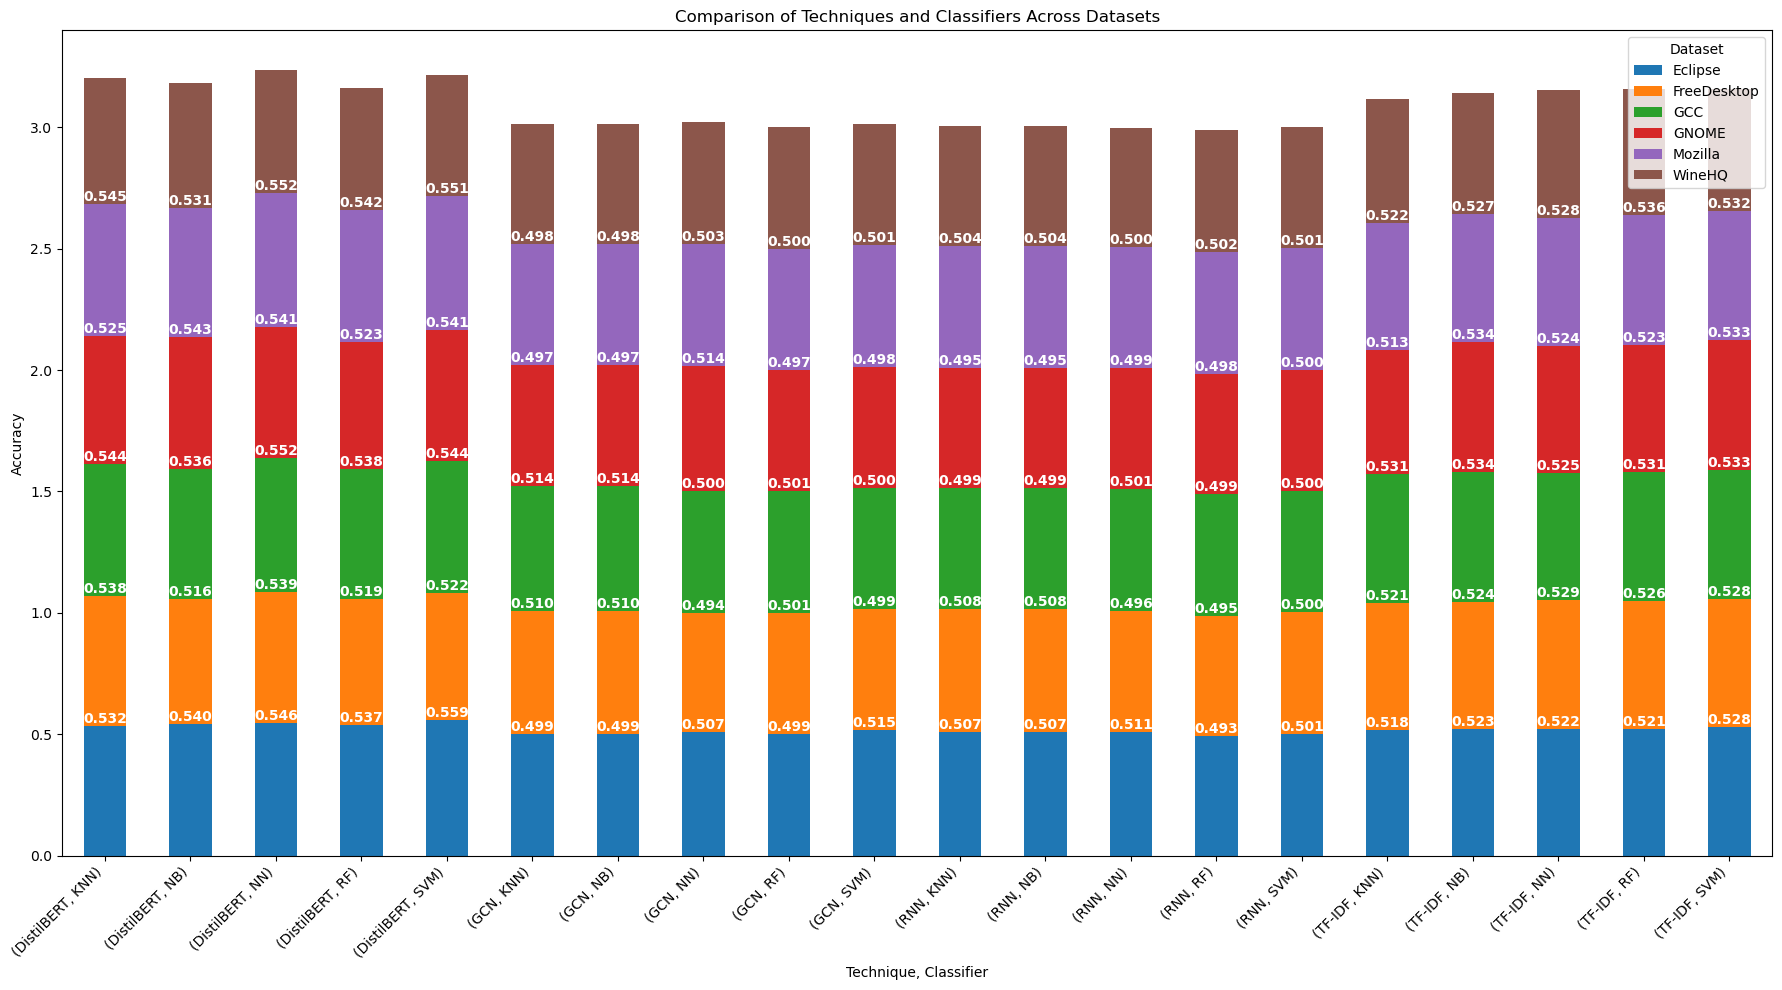

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for plotting
pivot_df = df_filtered.pivot_table(index=['Technique', 'Classifier'], columns='Dataset', values='Comparison')

# Function to annotate only the topmost segment of each bar
def annotate_top_values(ax):
    for rect in ax.patches:
        if rect.get_height() > 0:  # Check if the segment has height
            x = rect.get_x() + rect.get_width() / 2  # x-coordinate of the center of the bar
            y = rect.get_y() + rect.get_height()  # y-coordinate of the top of the segment
            height = rect.get_height()  # height of the segment
            ax.annotate(f'{height:.3f}', (x, y), ha='center', va='bottom', fontsize=10, color='white', weight='bold')

# Plotting the bar chart
plt.figure(figsize=(18, 10))
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(18, 10))
plt.title('Comparison of Techniques and Classifiers Across Datasets')
plt.xlabel('Technique, Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

# Add annotations for topmost values in each bar
annotate_top_values(ax)

plt.tight_layout()
plt.show()


<Figure size 1800x1000 with 0 Axes>

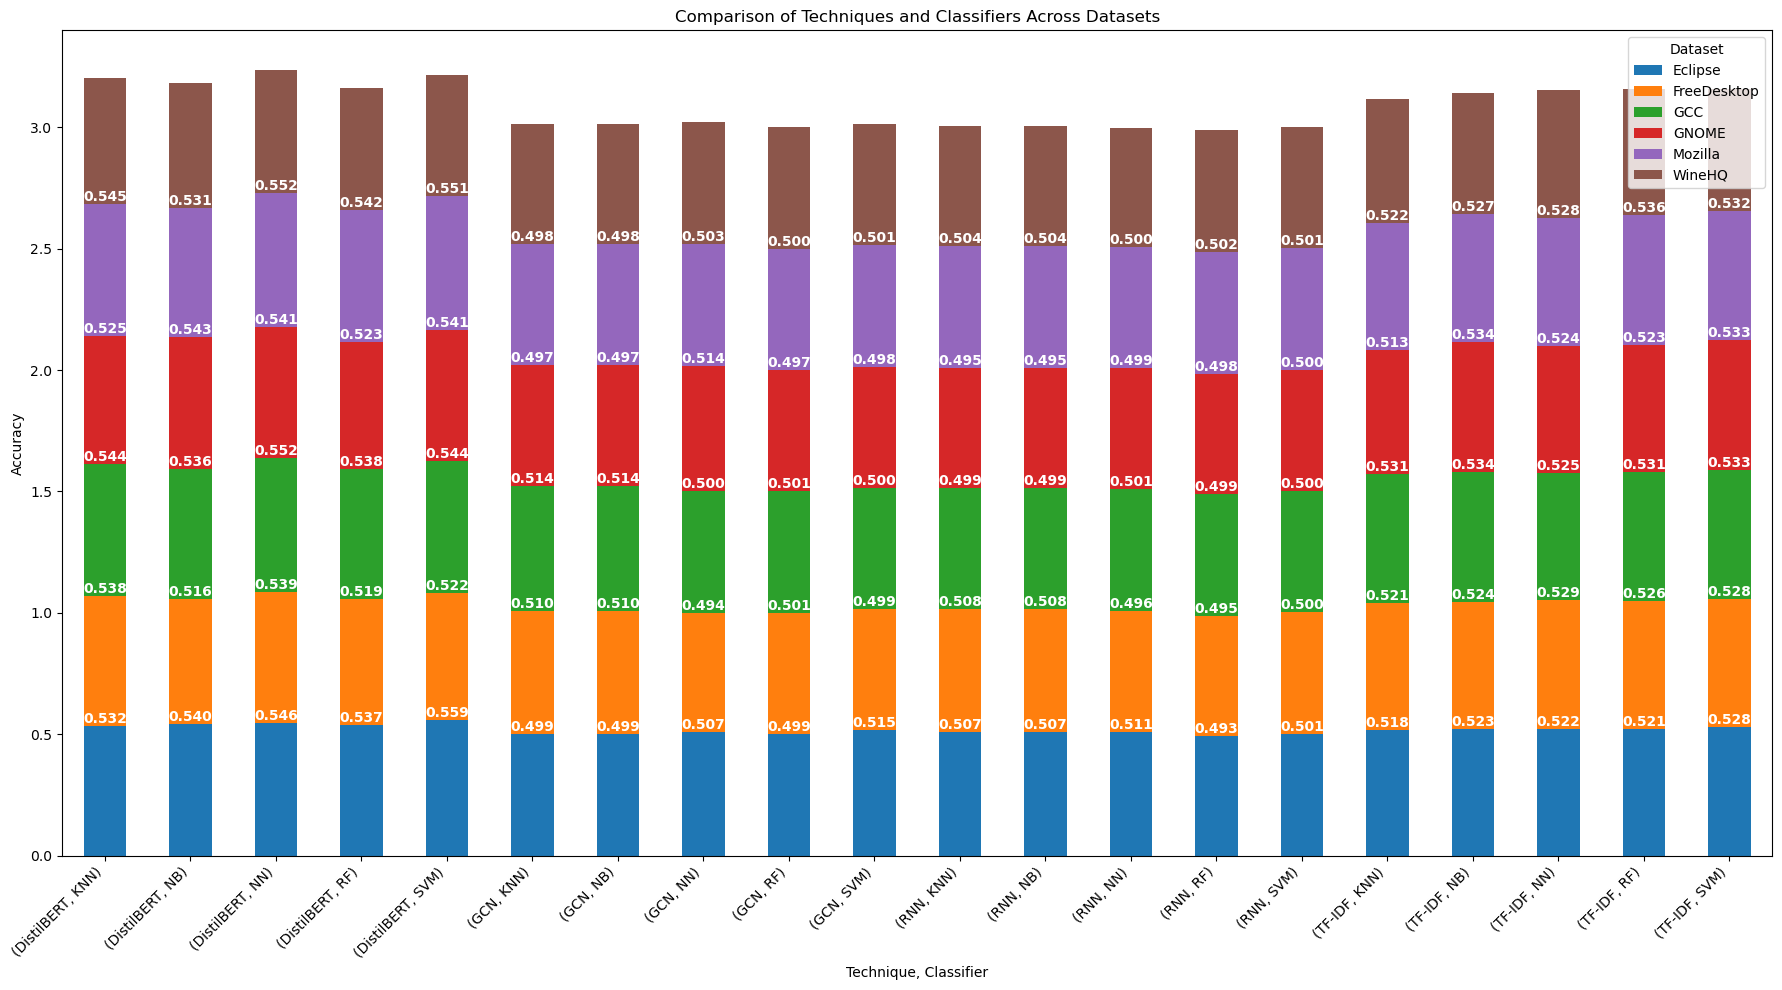

NameError: name 'overall_best_dataset' is not defined

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for plotting
pivot_df = df_filtered.pivot_table(index=['Technique', 'Classifier'], columns='Dataset', values='Comparison')

# Function to shuffle the colors for each segment in a bar
def shuffle_colors(ax):
    for c in ax.containers:
        np.random.shuffle(c.patches)

# Function to annotate only the topmost segment of each bar
def annotate_top_values(ax):
    for rect in ax.patches:
        if rect.get_height() > 0:  # Check if the segment has height
            x = rect.get_x() + rect.get_width() / 2  # x-coordinate of the center of the bar
            y = rect.get_y() + rect.get_height()  # y-coordinate of the top of the segment
            height = rect.get_height()  # height of the segment
            ax.annotate(f'{height:.3f}', (x, y), ha='center', va='bottom', fontsize=10, color='white', weight='bold')

# Plotting the bar chart
plt.figure(figsize=(18, 10))
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(18, 10))
plt.title('Comparison of Techniques and Classifiers Across Datasets')
plt.xlabel('Technique, Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

# Shuffle colors
shuffle_colors(ax)

# Add annotations for topmost values in each bar
annotate_top_values(ax)

plt.tight_layout()
plt.show()
print(f"\nOverall Best Dataset: {overall_best_dataset}")
print(f"Overall Best Classifier: {overall_best_classifier}")
print(f"Overall Best Technique: {overall_best_technique}")
print(f"Overall Best Accuracy: {overall_best_accuracy}")

<Figure size 1800x1000 with 0 Axes>

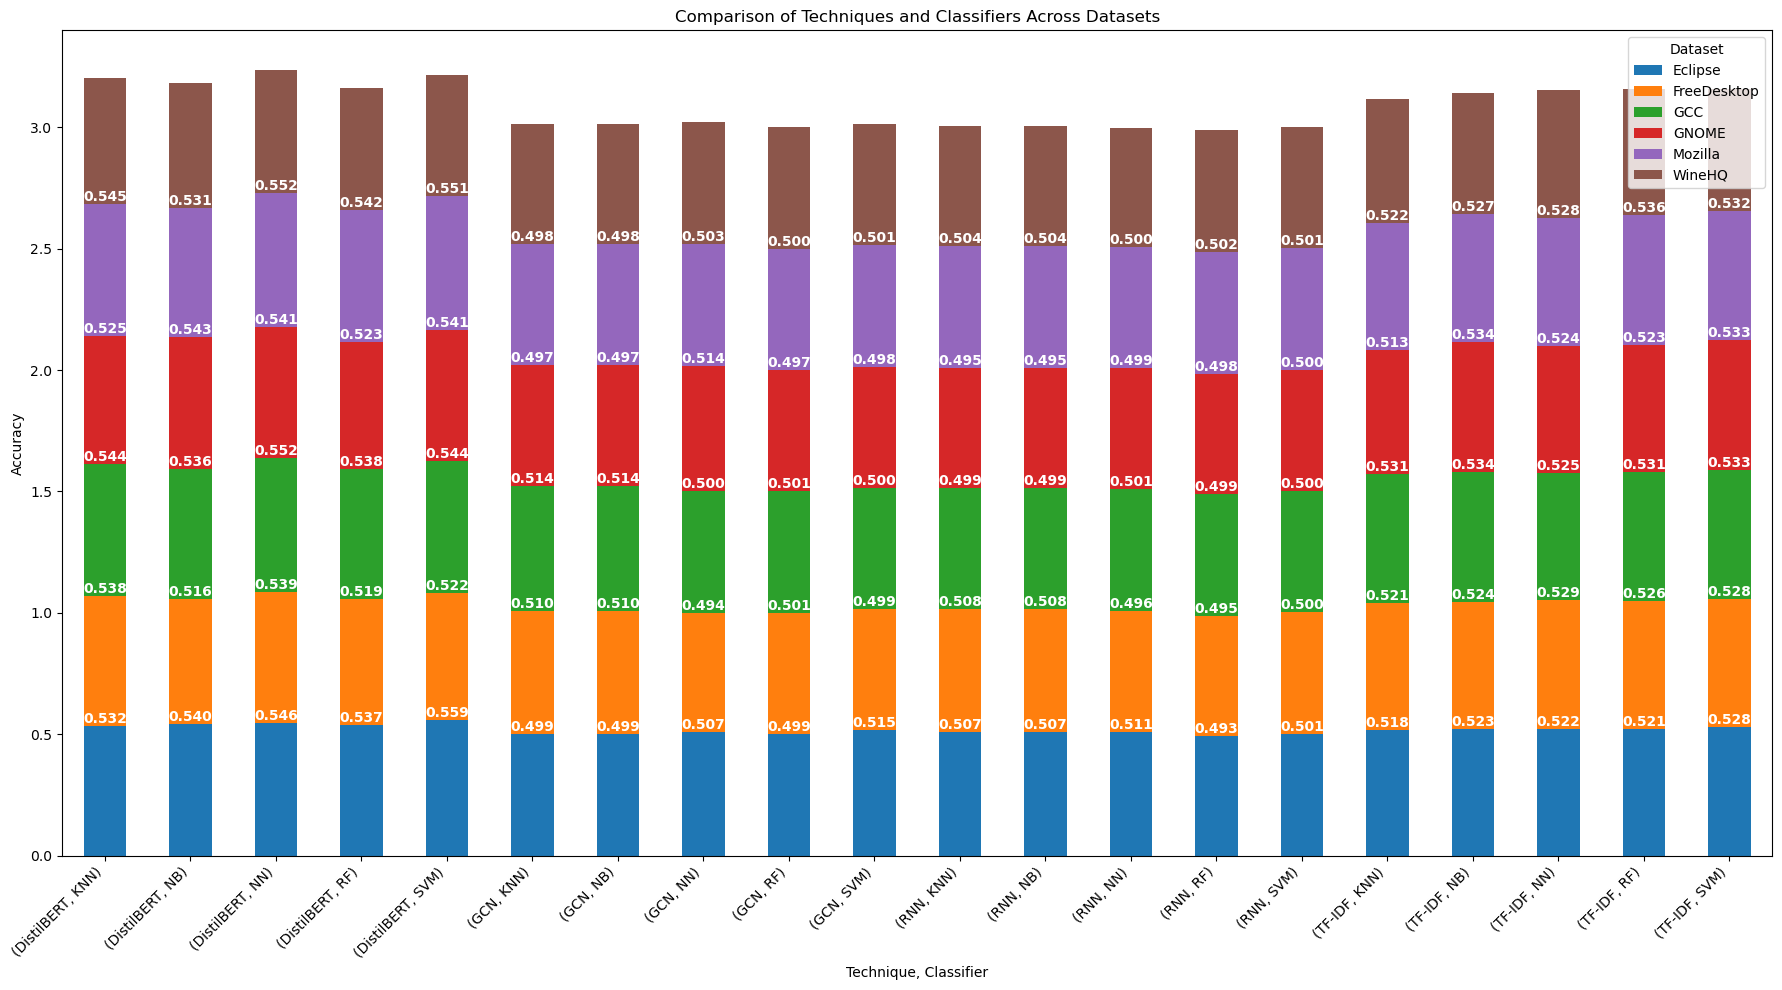

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for plotting
pivot_df = df_filtered.pivot_table(index=['Technique', 'Classifier'], columns='Dataset', values='Comparison')

# Function to annotate only the topmost segment of each bar
def annotate_top_values(ax):
    for container in ax.containers:
        for bar in container.patches:
            if bar.get_height() > 0:  # Check if the segment has height
                x = bar.get_x() + bar.get_width() / 2  # x-coordinate of the center of the bar
                y = bar.get_y() + bar.get_height()  # y-coordinate of the top of the segment
                height = bar.get_height()  # height of the segment
                ax.annotate(f'{height:.3f}', (x, y), ha='center', va='bottom', fontsize=10, color='white', weight='bold')

# Plotting the bar chart
plt.figure(figsize=(18, 10))
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(18, 10))
plt.title('Comparison of Techniques and Classifiers Across Datasets')
plt.xlabel('Technique, Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

# Add annotations for topmost values in each bar
annotate_top_values(ax)

plt.tight_layout()
plt.show()


<Figure size 1800x1000 with 0 Axes>

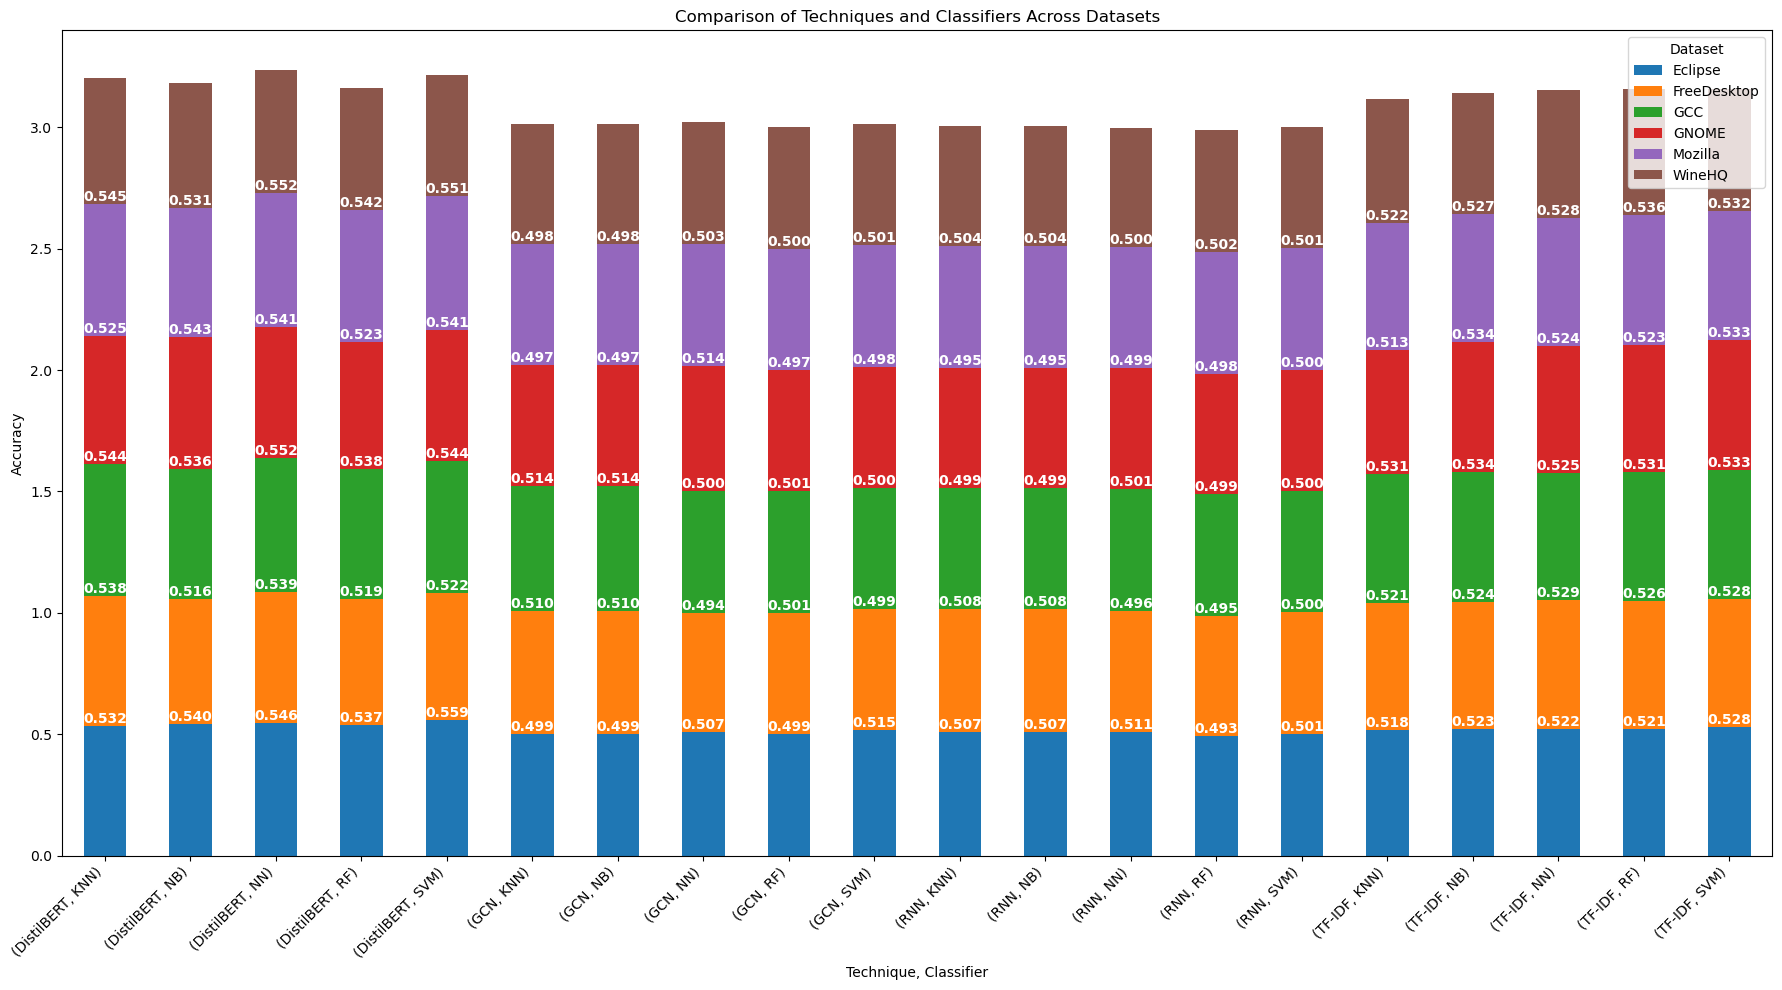

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV
df = pd.read_csv('resultss.csv')

# Filter data for the required techniques and classifiers
techniques = ['TF-IDF', 'DistilBERT', 'GCN', 'RNN']
classifiers = df['Classifier'].unique()

df_filtered = df[(df['Technique'].isin(techniques)) & (df['Classifier'].isin(classifiers))]

# Pivot the dataframe to create a matrix for plotting
pivot_df = df_filtered.pivot_table(index=['Technique', 'Classifier'], columns='Dataset', values='Comparison')

# Sort values within each group in descending order
pivot_df = pivot_df.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Function to annotate only the topmost segment of each bar
def annotate_top_values(ax):
    for container in ax.containers:
        for bar in container.patches:
            if bar.get_height() > 0:  # Check if the segment has height
                x = bar.get_x() + bar.get_width() / 2  # x-coordinate of the center of the bar
                y = bar.get_y() + bar.get_height()  # y-coordinate of the top of the segment
                height = bar.get_height()  # height of the segment
                ax.annotate(f'{height:.3f}', (x, y), ha='center', va='bottom', fontsize=10, color='white', weight='bold')

# Plotting the bar chart
plt.figure(figsize=(18, 10))
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(18, 10))
plt.title('Comparison of Techniques and Classifiers Across Datasets')
plt.xlabel('Technique, Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

# Add annotations for topmost values in each bar
annotate_top_values(ax)

plt.tight_layout()
plt.show()


In [1]:
from tabulate import tabulate

def print_table(data):
    # Define header and format for DistilBERT
    header = ["Dataset", "Classifier", "Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1-score"]

    # Combine header and data
    table_data = [header] + data

    # Print table using tabulate
    table_str = tabulate(table_data, headers="firstrow", tablefmt="pipe")

    # Print the table
    print(table_str)


# Define the data
result_data = [
    ["Mozilla", "DistilBERT_Scaled", "0.626517", "0.530296", "0.593743", "0.626517", "0.577323"],
    ["Mozilla", "GCN", "0.628241", "0.500000", "0.402161", "0.628241", "0.488062"],
    ["Mozilla", "RNN", "0.628241", "0.500000", "0.402161", "0.628241", "0.488062"],
    ["Mozilla", "TF-IDF", "0.634420", "0.525316", "0.589817", "0.634420", "0.567753"],
    
    ["Eclipse", "DistilBERT_Scaled", "0.599405", "0.531906", "0.580077", "0.599405", "0.586271"],
    ["Eclipse", "GCN", "0.574259", "0.499789", "0.547222", "0.574259", "0.556116"],
    ["Eclipse", "RNN", "0.573659", "0.498756", "0.546794", "0.573659", "0.555359"],
    ["Eclipse", "TF-IDF", "0.598858", "0.522643", "0.572657", "0.598858", "0.577571"],
    
    ["GCC", "DistilBERT_Scaled", "0.628832", "0.539773", "0.600211", "0.628832", "0.583194"],
    ["GCC", "GCN", "0.568047", "0.497440", "0.545269", "0.568047", "0.553484"],
    ["GCC", "RNN", "0.628241", "0.500000", "0.402161", "0.628241", "0.488062"],
    ["GCC", "TF-IDF", "0.603316", "0.525552", "0.576195", "0.603316", "0.579141"],
    
    ["GNOME", "DistilBERT_Scaled", "0.635799", "0.529145", "0.601470", "0.635799", "0.574636"],
    ["GNOME", "GCN", "0.621864", "0.500740", "0.544079", "0.621864", "0.520729"],
    ["GNOME", "RNN", "0.547468", "0.499496", "0.546528", "0.547468", "0.546917"],
    ["GNOME", "TF-IDF", "0.615215", "0.527103", "0.582214", "0.615215", "0.580376"],
    
    ["WineHQ", "DistilBERT_Scaled", "0.644207", "0.536452", "0.605146", "0.644207", "0.581485"],
    ["WineHQ", "GCN", "0.623916", "0.499818", "0.503598", "0.623916", "0.511932"],
    ["WineHQ", "RNN", "0.628241", "0.500000", "0.402161", "0.628241", "0.488062"],
    ["WineHQ", "TF-IDF", "0.632227", "0.527057", "0.603875", "0.632227", "0.573563"],
    
    ["FreeDesktop", "DistilBERT_Scaled", "0.626517", "0.530296", "0.593743", "0.626517", "0.577323"],
    ["FreeDesktop", "GCN", "0.628241", "0.500000", "0.402161", "0.628241", "0.488062"],
    ["FreeDesktop", "RNN", "0.628241", "0.500000", "0.402161", "0.628241", "0.488062"],
    ["FreeDesktop", "TF-IDF", "0.634420", "0.525316", "0.589817", "0.634420", "0.567753"]
]

# Print the table
print_table(result_data)


| Dataset     | Classifier        |   Accuracy |   Balanced Accuracy |   Precision |   Recall |   F1-score |
|:------------|:------------------|-----------:|--------------------:|------------:|---------:|-----------:|
| Mozilla     | DistilBERT_Scaled |   0.626517 |            0.530296 |    0.593743 | 0.626517 |   0.577323 |
| Mozilla     | GCN               |   0.628241 |            0.5      |    0.402161 | 0.628241 |   0.488062 |
| Mozilla     | RNN               |   0.628241 |            0.5      |    0.402161 | 0.628241 |   0.488062 |
| Mozilla     | TF-IDF            |   0.63442  |            0.525316 |    0.589817 | 0.63442  |   0.567753 |
| Eclipse     | DistilBERT_Scaled |   0.599405 |            0.531906 |    0.580077 | 0.599405 |   0.586271 |
| Eclipse     | GCN               |   0.574259 |            0.499789 |    0.547222 | 0.574259 |   0.556116 |
| Eclipse     | RNN               |   0.573659 |            0.498756 |    0.546794 | 0.573659 |   0.555359 |
| Eclipse     | TF-